<a href="https://colab.research.google.com/github/theSadiqali/Advance-Data-Science-Project/blob/main/complete__(3)_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Section 1: Imports and Setup**

This section imports necessary libraries for data loading (h5py, os), array handling (numpy), visualization (matplotlib), progress tracking (tqdm), data analysis (pandas, Counter), and image processing (cv2, skimage, scipy.ndimage).

In [ ]:

## Required Library

import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from collections import Counter, defaultdict
import cv2
from skimage import restoration, img_as_ubyte
from scipy.ndimage import median_filter



In [ ]:
import kagglehub    # Importing the dataset

# Download latest version
path = kagglehub.dataset_download("ashkhagan/figshare-brain-tumor-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/figshare-brain-tumor-dataset


The goal of this section is to load and explore a sample MRI scan from the dataset, understand the file structure, and visualize the brain scan with and without tumor masks.

This is the first step in understanding what’s inside the .mat dataset before moving to preprocessing and model building.

**Section 2: Data Exploration and Visualization**

I performed Data Exploration and Visualization on a sample MRI scan from the Figshare Brain Tumor Dataset.

['PID', 'image', 'label', 'tumorBorder', 'tumorMask']


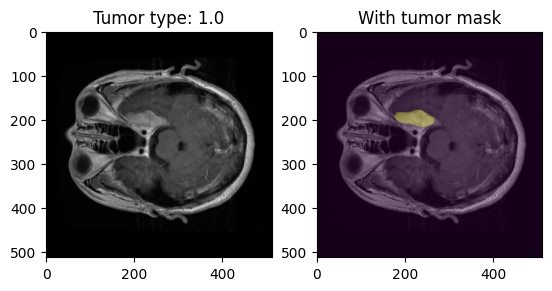

In [ ]:
# Explore the first .mat file
# Extract the brain scan image and pull out the brain scan image,
# Tumor type, and tumor mask, and displays two plots: one showing the brain scan
# And another with the tumor mask overlaid to show where the tumor is.
sample_mat = '/kaggle/input/figshare-brain-tumor-dataset/dataset/data/100.mat'
with h5py.File(sample_mat, 'r') as mat:
    cjdata = mat['cjdata']
    print(list(cjdata.keys()))
    image = np.array(cjdata['image'])
    label = np.array(cjdata['label'])[0][0]
    tumor_mask = np.array(cjdata['tumorMask'])

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title(f'Tumor type: {label}')
plt.subplot(1, 2, 2)
plt.imshow(image, cmap='gray')
plt.imshow(tumor_mask, alpha=0.3)
plt.title('With tumor mask')
plt.show()


**Section 3: Data Loading and Features Table**


I started by loading all .mat files from the Dataset. These files contain MRI images, tumor masks, and labels. There are 3064 images in total.

In [ ]:
# Sets up the file list and tumor type labels for further processing,
# Like loading or analyzing brain tumor data, and tells you how many files are available.
input_dir = '/kaggle/input/figshare-brain-tumor-dataset/dataset/data/'
mat_files = [f for f in os.listdir(input_dir) if f.endswith('.mat')]
label_map = {1: "meningioma", 2: "glioma", 3: "pituitary"}
print(f"Found {len(mat_files)} .mat files.")


Found 3064 .mat files.


In [ ]:
# checks the folder for brain tumor data files,
# counts them, and displays the names of the first five to give a quick look at the files available.


input_dir = '/kaggle/input/figshare-brain-tumor-dataset/dataset/data/'
mat_files = [f for f in os.listdir(input_dir) if f.endswith('.mat')]
print(f"Found {len(mat_files)} .mat files.")
print(mat_files[:5])  # Show first 5 file names


Found 3064 .mat files.
['2912.mat', '2011.mat', '3027.mat', '1912.mat', '3023.mat']


In [ ]:
# loops through brain tumor data files (.mat), gets the tumor type number from each,
# stores them in a list, and prints how many labels were collected plus the first 10 labels.
labels = []

for filename in mat_files:
    with h5py.File(os.path.join(input_dir, filename), 'r') as mat:
        cjdata = mat['cjdata']
        label = int(np.array(cjdata['label'])[0][0])
        labels.append(label)

print(f"Collected labels for {len(labels)} images.")
print("Example labels:", labels[:10])


Collected labels for 3064 images.
Example labels: [2, 2, 2, 2, 2, 1, 3, 2, 2, 2]


In [ ]:
from collections import Counter

# We count how many times each tumor type appeared in the dataset and used the label_map to show the names instead of numbers

label_map = {1: "meningioma", 2: "glioma", 3: "pituitary"}
counts = Counter(labels)

for k in sorted(counts.keys()):
    print(f"{label_map[k]:<12}: {counts[k]}")


meningioma  : 708
glioma      : 1426
pituitary   : 930


In Section 4, I performed Exploratory Data Analysis to better understand the Figshare Brain Tumor Dataset.
I analyzed tumor type distributions, patient-wise image counts, tumor sizes, and created visualizations like bar charts, histograms, and heatmaps to extract important insights before preprocessing and training the model.


**Section 4: Exploratory Data Analysis (EDA)**

This section analyzes the dataset distribution (e.g: tumor types, patient slices) and visualizes key insights using charts.

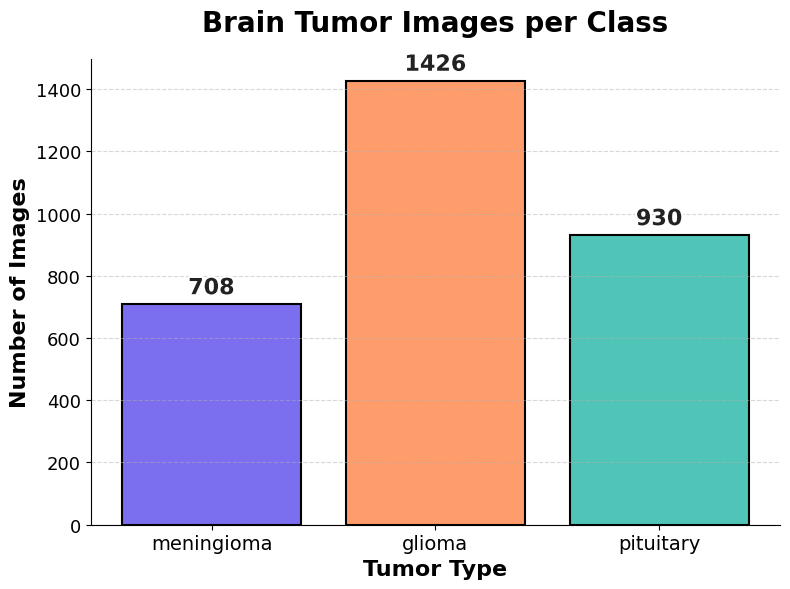

In [ ]:
# we are making a chart to show how many brain scan slices each patient has
# Count images per patient, and note tumor type per patient

import matplotlib.patheffects as path_effects


# Add these two lines:
class_names = [label_map[k] for k in sorted(counts.keys())]
class_counts = [counts[k] for k in sorted(counts.keys())]

colors = ['#7B6FF0', '#FF9C6B', '#50C5B7']

fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(class_names, class_counts, color=colors, edgecolor='black', linewidth=1.5)

for bar in bars:
    yval = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        yval + 20,
        f'{yval}',
        ha='center', va='bottom',
        fontsize=16, fontweight='bold', color='#222',
        path_effects=[path_effects.withStroke(linewidth=3, foreground="white")]
    )

ax.set_xlabel('Tumor Type', fontsize=16, fontweight='bold')
ax.set_ylabel('Number of Images', fontsize=16, fontweight='bold')
ax.set_title('Brain Tumor Images per Class', fontsize=20, fontweight='bold', pad=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=14, fontweight='medium')
plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()


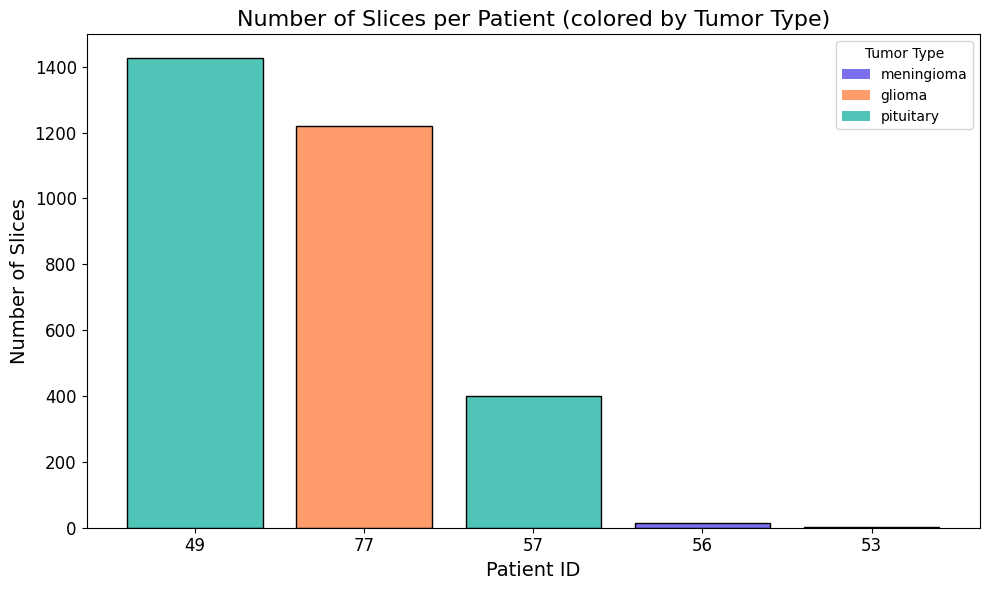

In [ ]:
import matplotlib.pyplot as plt

# Count images per patient, and note tumor type per patient
pid_slice_counts = {}
pid_tumor_type = {}

for filename in mat_files:
    with h5py.File(os.path.join(input_dir, filename), 'r') as mat:
        cjdata = mat['cjdata']
        label = int(np.array(cjdata['label'])[0][0])
        pid = int(np.array(cjdata['PID'])[0][0])
        pid_slice_counts[pid] = pid_slice_counts.get(pid, 0) + 1
        pid_tumor_type[pid] = label  # Assumes each patient has only one tumor type

# Sort by number of slices
sorted_pids = sorted(pid_slice_counts, key=pid_slice_counts.get, reverse=True)
counts = [pid_slice_counts[pid] for pid in sorted_pids]
colors = [label_map[pid_tumor_type[pid]] for pid in sorted_pids]
color_map = {'meningioma': '#7B6FF0', 'glioma': '#FF9C6B', 'pituitary': '#50C5B7'}
bar_colors = [color_map[c] for c in colors]

plt.figure(figsize=(10,6))
bars = plt.bar([str(pid) for pid in sorted_pids], counts, color=bar_colors, edgecolor='black')

plt.xlabel("Patient ID", fontsize=14)
plt.ylabel("Number of Slices", fontsize=14)
plt.title("Number of Slices per Patient (colored by Tumor Type)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Custom legend
for tumor, color in color_map.items():
    plt.bar(0, 0, color=color, label=tumor)
plt.legend(title="Tumor Type")
plt.tight_layout()
plt.show()


In [ ]:
# checks the image and mask sizes in the dataset and calculates how much of each image is covered by the tumor (in pixels and %).

img_shapes = []
mask_shapes = []
mask_areas = []
mask_fractions = []

for filename in mat_files:
    with h5py.File(os.path.join(input_dir, filename), 'r') as mat:
        cjdata = mat['cjdata']
        image = np.array(cjdata['image'])
        mask = np.array(cjdata['tumorMask'])
        img_shapes.append(image.shape)
        mask_shapes.append(mask.shape)
        mask_areas.append(mask.sum())
        mask_fractions.append(mask.sum() / (mask.shape[0] * mask.shape[1]))

# Show unique shapes
print("Unique image shapes:", set(img_shapes))
print("Unique mask shapes:", set(mask_shapes))

# Basic mask stats
import numpy as np
print(f"Avg tumor area (pixels): {np.mean(mask_areas):.1f}")
print(f"Avg tumor % of image: {np.mean(mask_fractions)*100:.2f}%")
print(f"Max tumor % of image: {np.max(mask_fractions)*100:.2f}%")
print(f"Min tumor % of image: {np.min(mask_fractions)*100:.2f}%")


Unique image shapes: {(512, 512), (256, 256)}
Unique mask shapes: {(512, 512), (256, 256)}
Avg tumor area (pixels): 4421.7
Avg tumor % of image: 1.69%
Max tumor % of image: 9.71%
Min tumor % of image: 0.10%


In [ ]:
from collections import defaultdict
import numpy as np

# calculates tumor statistics separately for each tumor type. For every class,
# Measured the average tumor area in pixels and the percentage of the image that the tumor covers.

# Gather mask sizes by class
mask_areas_by_label = defaultdict(list)
mask_frac_by_label = defaultdict(list)

for filename in mat_files:
    with h5py.File(os.path.join(input_dir, filename), 'r') as mat:
        cjdata = mat['cjdata']
        label = int(np.array(cjdata['label'])[0][0])
        mask = np.array(cjdata['tumorMask'])
        mask_areas_by_label[label].append(mask.sum())
        mask_frac_by_label[label].append(mask.sum() / (mask.shape[0] * mask.shape[1]))

print("Average tumor area (pixels) and % of image, per tumor type:")
for label in sorted(mask_areas_by_label):
    mean_area = np.mean(mask_areas_by_label[label])
    mean_frac = np.mean(mask_frac_by_label[label]) * 100
    print(f"{label_map[label]:<12}: {mean_area:.1f} pixels, {mean_frac:.2f}% of image")


Average tumor area (pixels) and % of image, per tumor type:
meningioma  : 4654.7 pixels, 1.78% of image
glioma      : 5778.6 pixels, 2.20% of image
pituitary   : 2163.9 pixels, 0.84% of image


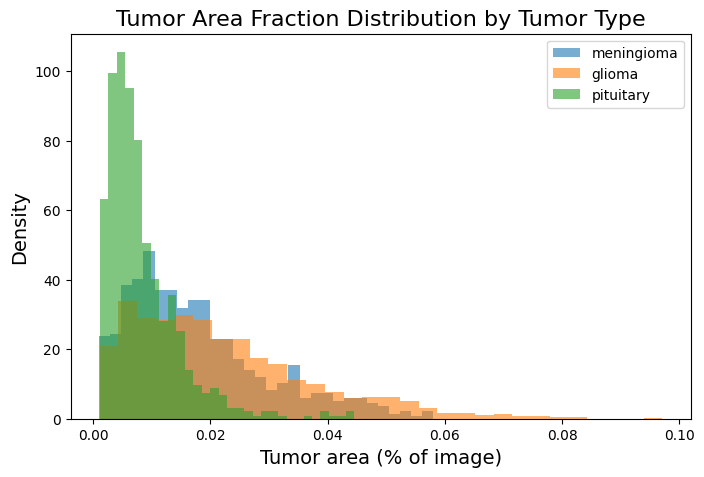

In [ ]:
import matplotlib.pyplot as plt

# chart with bars to show how big tumors are (as a percentage of the image) for each type (like meningioma).
plt.figure(figsize=(8,5))
for label in sorted(mask_areas_by_label):
    plt.hist(
        mask_frac_by_label[label],
        bins=30,
        alpha=0.6,
        label=label_map[label],
        density=True
    )
plt.xlabel('Tumor area (% of image)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Tumor Area Fraction Distribution by Tumor Type', fontsize=16)
plt.legend()
plt.show()


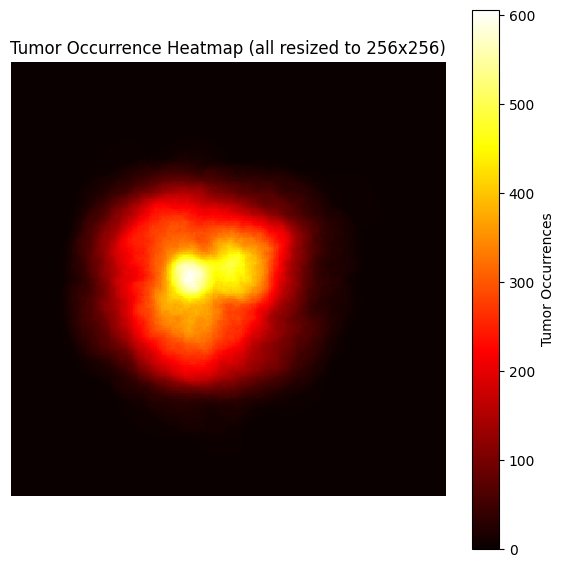

In [ ]:
from skimage.transform import resize
# makes a picture called a heatmap to show where tumors are most common.
# It stacks all the tumor masks, resizes them to 256x256, and uses red colors to show where there are more tumors.

target_shape = (256, 256)
heatmap = np.zeros(target_shape)

for filename in mat_files:
    with h5py.File(os.path.join(input_dir, filename), 'r') as mat:
        mask = np.array(mat['cjdata']['tumorMask'])
        # Resize to target shape, preserve binary mask
        mask_resized = resize(mask, target_shape, order=0, preserve_range=True, anti_aliasing=False)
        heatmap += mask_resized

plt.figure(figsize=(7,7))
plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.colorbar(label='Tumor Occurrences')
plt.title('Tumor Occurrence Heatmap (all resized to 256x256)')
plt.axis('off')
plt.show()


In [ ]:
# counts how many brain scan slices each patient has.
# looks at every file, adds 1 to the count for each patient’s ID,
# then tells us the smallest, biggest, average, and middle number of slices.

pid_slice_counts = defaultdict(int)
for filename in mat_files:
    with h5py.File(os.path.join(input_dir, filename), 'r') as mat:
        pid = int(np.array(mat['cjdata']['PID'])[0][0])
        pid_slice_counts[pid] += 1

slice_counts = list(pid_slice_counts.values())
print(f"Min slices per patient: {np.min(slice_counts)}")
print(f"Max slices per patient: {np.max(slice_counts)}")
print(f"Mean slices per patient: {np.mean(slice_counts):.1f}")
print(f"Median slices per patient: {np.median(slice_counts)}")


Min slices per patient: 2
Max slices per patient: 1427
Mean slices per patient: 612.8
Median slices per patient: 401.0


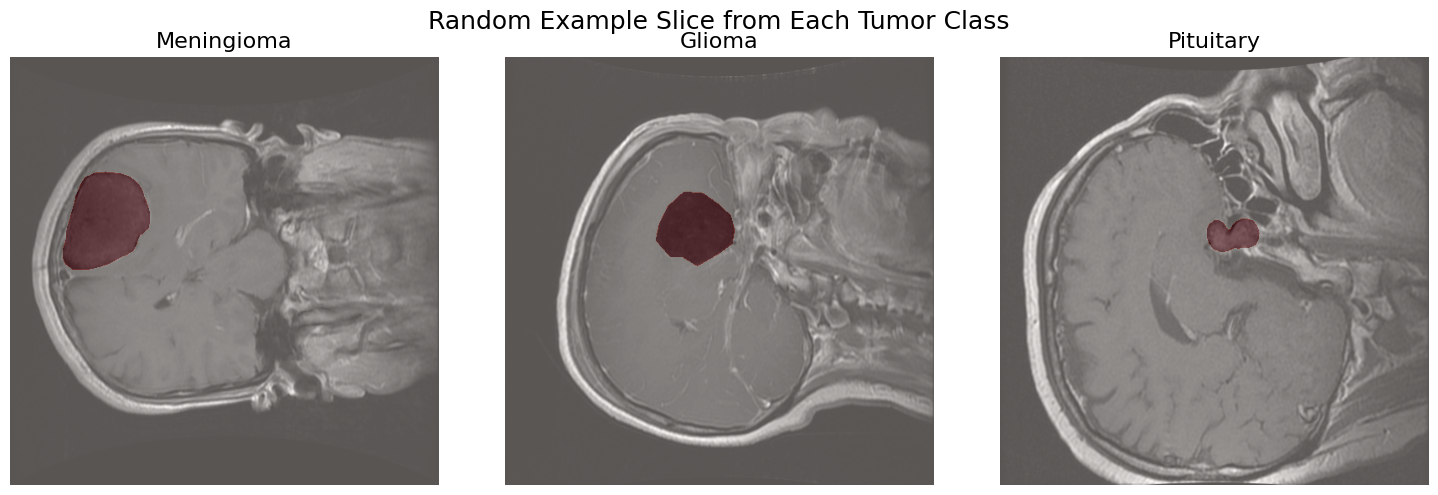

In [ ]:
import random
import matplotlib.pyplot as plt

# picks one random brain scan for each tumor type,
# shows them in three side-by-side pictures with red tumor masks

plt.figure(figsize=(15, 5))

for i, label in enumerate(sorted(label_map)):
    # Find all files for this class
    files_for_label = [
        f for f in mat_files
        if int(np.array(h5py.File(os.path.join(input_dir, f), 'r')['cjdata']['label'])[0][0]) == label
    ]
    # Pick a random file for this class
    random_file = random.choice(files_for_label)
    with h5py.File(os.path.join(input_dir, random_file), 'r') as mat:
        image = np.array(mat['cjdata']['image'])
        mask = np.array(mat['cjdata']['tumorMask'])
    plt.subplot(1, 3, i + 1)
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, alpha=0.35, cmap='Reds')
    plt.title(f"{label_map[label].capitalize()}", fontsize=16)
    plt.axis('off')

plt.suptitle('Random Example Slice from Each Tumor Class', fontsize=18)
plt.tight_layout()
plt.show()

In [ ]:
# counts how many brain scan images have no tumor, a full tumor, or something else.
# It checks each mask, adds to empty if no tumor, full if all tumor, and total for all,
# then prints the numbers.

empty = 0
full = 0
total = 0

for filename in mat_files:
    with h5py.File(os.path.join(input_dir, filename), 'r') as mat:
        mask = np.array(mat['cjdata']['tumorMask'])
        total += 1
        if mask.sum() == 0:
            empty += 1
        elif mask.sum() == mask.size:
            full += 1

print(f"Out of {total} images:")
print(f"- Number with empty tumor mask (no tumor): {empty}")
print(f"- Number with full tumor mask (entire image): {full}")


Out of 3064 images:
- Number with empty tumor mask (no tumor): 0
- Number with full tumor mask (entire image): 0


Classification Data Analysis


In [ ]:
# checks all brain scan image sizes, lists them, finds the unique sizes, and prints them.

img_shapes = []
for filename in mat_files:
    with h5py.File(os.path.join(input_dir, filename), 'r') as mat:
        image = np.array(mat['cjdata']['image'])
        img_shapes.append(image.shape)

unique_shapes = set(img_shapes)
print("Unique image shapes in dataset:", unique_shapes)


Unique image shapes in dataset: {(512, 512), (256, 256)}


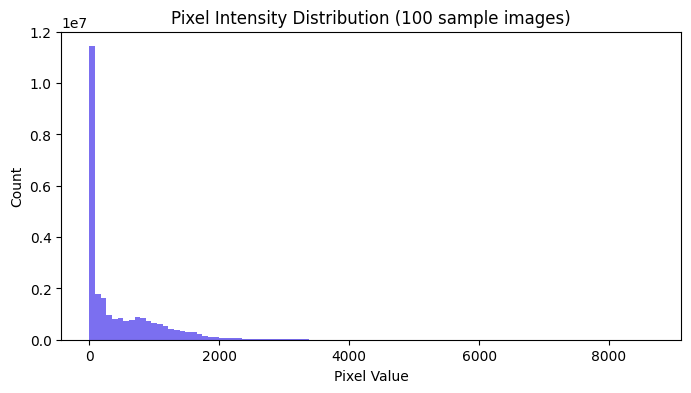

In [ ]:
import matplotlib.pyplot as plt

# checks pixel brightness in 100 brain scans, makes a purple bar chart showing
# how common each brightness is, and labels it "Pixel Intensity Distribution (100 sample images)" with "Pixel Value" and "Count".
sample_pixels = []
for i, filename in enumerate(mat_files[:100]):  # Just 100 for speed
    with h5py.File(os.path.join(input_dir, filename), 'r') as mat:
        image = np.array(mat['cjdata']['image'])
        sample_pixels.extend(image.flatten())

plt.figure(figsize=(8,4))
plt.hist(sample_pixels, bins=100, color='#7B6FF0')
plt.title("Pixel Intensity Distribution (100 sample images)")
plt.xlabel("Pixel Value")
plt.ylabel("Count")
plt.show()


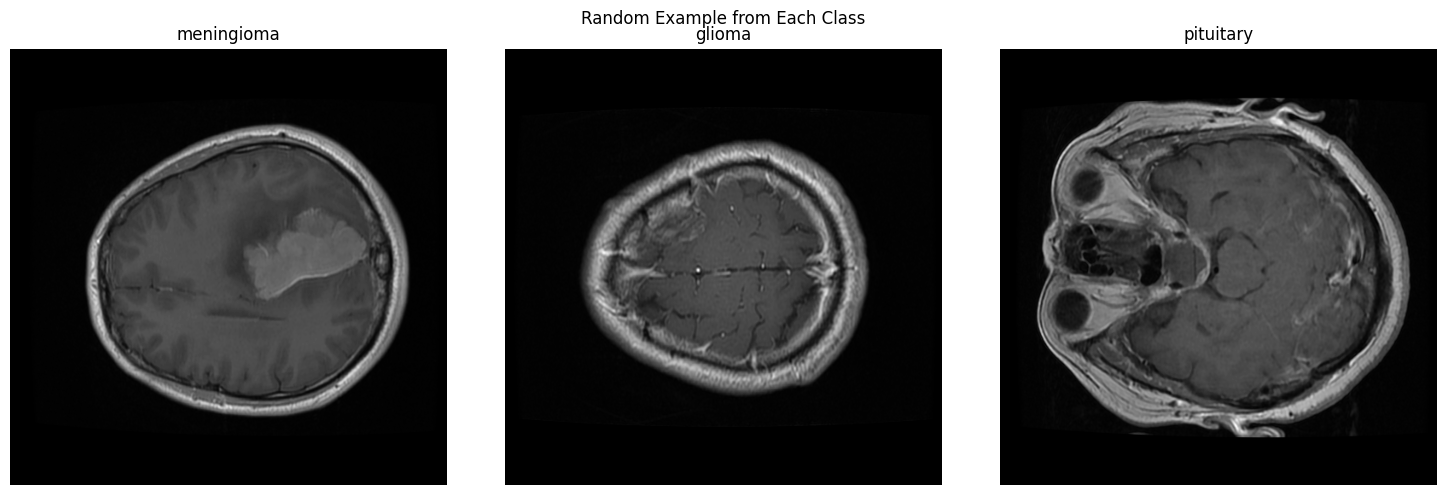

In [ ]:
import random

# Shows three random brain scan images, one per tumor type, in a single grayscale plot with tumor names and a title.
plt.figure(figsize=(15,5))
for i, label in enumerate(sorted(label_map)):
    files_for_label = [
        f for f in mat_files
        if int(np.array(h5py.File(os.path.join(input_dir, f), 'r')['cjdata']['label'])[0][0]) == label
    ]
    random_file = random.choice(files_for_label)
    with h5py.File(os.path.join(input_dir, random_file), 'r') as mat:
        image = np.array(mat['cjdata']['image'])
    plt.subplot(1, 3, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(label_map[label])
    plt.axis('off')
plt.suptitle("Random Example from Each Class")
plt.tight_layout()
plt.show()


In Section 5, I performed image preprocessing to improve the quality of MRI scans and prepare the data for deep learning models.
The preprocessing steps include grayscale conversion, resizing, CLAHE (Contrast Limited Adaptive Histogram Equalization), normalization.
These steps ensure consistent image quality, enhance tumor visibility, and make the dataset ready for training CNNs and Vision Transformers.

**Section 5: Image Preprocessing**

1. CLAHE for contrast enhancement
2. Median filter for noise removal
3. Normalization of pixel values


In [ ]:
# preprocess_mri_dl_soft cleans and resizes an MRI image to 224x224.
# preprocess_mask resizes a tumor mask to 224x224 and makes it binary (0s and 1s).
# Median filter: reducing noise without blurring important details. like keeping edges clear.
def preprocess_mri_dl_soft(image):
    img = image.astype(np.uint8) if image.max() > 1 else img_as_ubyte(image)
    img = median_filter(img, size=3)
    img = cv2.bilateralFilter(img, d=9, sigmaColor=40, sigmaSpace=40)
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    img = img.astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
    return img

def preprocess_mask(mask):
    mask = mask.astype(np.uint8)
    mask = cv2.resize(mask, (224, 224), interpolation=cv2.INTER_NEAREST)
    mask = (mask > 0).astype(np.uint8)
    return mask


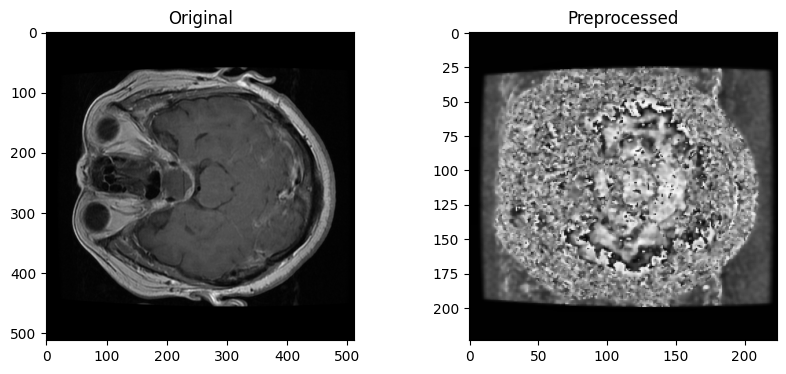

In [ ]:
#  shows two side-by-side images: the original MRI scan and its preprocessed version
# (smoothed, enhanced, resized to 224x224) in grayscale, labeled "Original" and "Preprocessed."

dl_soft = preprocess_mri_dl_soft(image)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(image, cmap='gray'); plt.title('Original')
plt.subplot(1,2,2); plt.imshow(dl_soft, cmap='gray'); plt.title('Preprocessed')
plt.show()


In [ ]:
# Set your input and output directories
# It creates two folders (one for processed images, one for masks) and lists how many .mat files are in the input folder.
input_dir = '/kaggle/input/figshare-brain-tumor-dataset/dataset/data/'
preprocessed_img_dir = './preprocessed_images'
preprocessed_mask_dir = './preprocessed_masks'

os.makedirs(preprocessed_img_dir, exist_ok=True)
os.makedirs(preprocessed_mask_dir, exist_ok=True)

mat_files = [f for f in os.listdir(input_dir) if f.endswith('.mat')]
print(f"Found {len(mat_files)} .mat files.")


Found 3064 .mat files.


In [ ]:
input_dir = '/kaggle/input/figshare-brain-tumor-dataset/dataset/data/'  # update path if needed
mat_files = [f for f in os.listdir(input_dir) if f.endswith('.mat')]
label_map = {1: "meningioma", 2: "glioma", 3: "pituitary"}
print(f"Found {len(mat_files)} .mat files.")


Found 3064 .mat files.


In [ ]:
# processes MRI images and tumor masks from .mat files, saves them as .npy and .png files in new folders,
# and creates a CSV file listing file names and tumor types.

preprocessed_img_dir = './preprocessed_images'
preprocessed_mask_dir = './preprocessed_masks'
os.makedirs(preprocessed_img_dir, exist_ok=True)
os.makedirs(preprocessed_mask_dir, exist_ok=True)

meta = []
for filename in tqdm(mat_files):
    with h5py.File(os.path.join(input_dir, filename), 'r') as mat:
        cjdata = mat['cjdata']
        image = np.array(cjdata['image'])
        mask = np.array(cjdata['tumorMask'])
        label = int(np.array(cjdata['label'])[0][0])
        img_pre = preprocess_mri_dl_soft(image)
        mask_pre = preprocess_mask(mask)
        img_outfile = os.path.join(preprocessed_img_dir, filename.replace('.mat', '.npy'))
        mask_outfile = os.path.join(preprocessed_mask_dir, filename.replace('.mat', '.npy'))
        np.save(img_outfile, img_pre)
        np.save(mask_outfile, mask_pre)
        img_png_out = os.path.join(preprocessed_img_dir, filename.replace('.mat', '.png'))
        cv2.imwrite(img_png_out, (img_pre * 255).astype(np.uint8))
        meta.append({'filename': filename.replace('.mat', ''), 'label': label})

pd.DataFrame(meta).to_csv('preprocessed_labels.csv', index=False)


100%|██████████| 3064/3064 [04:47<00:00, 10.66it/s]


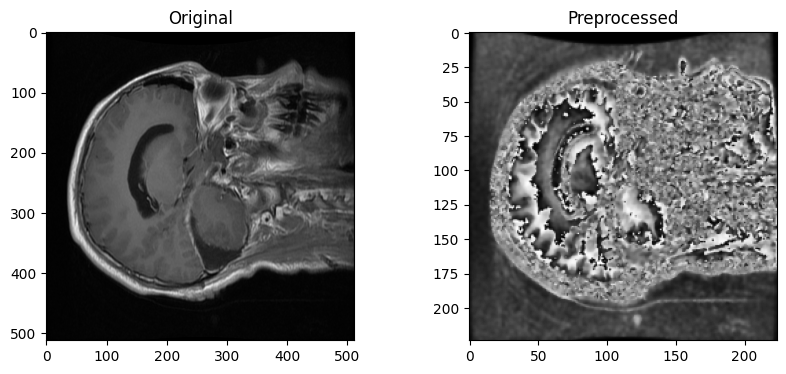

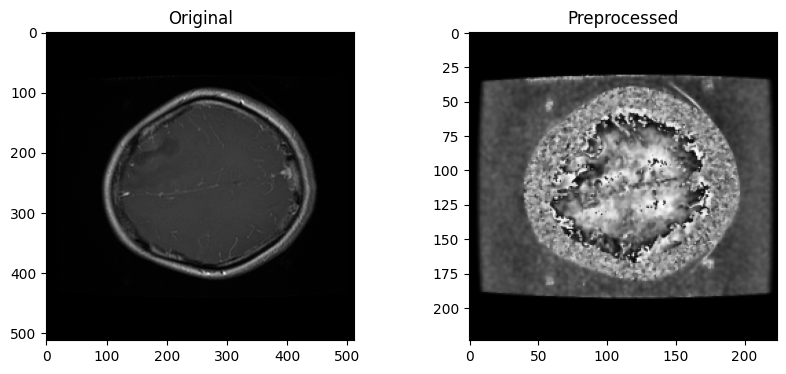

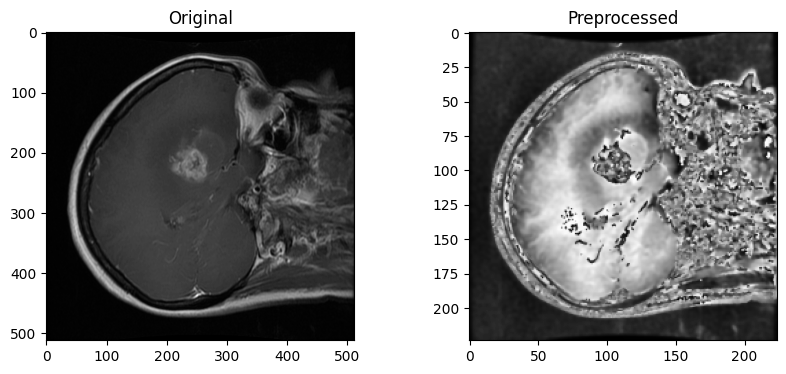

In [ ]:
# Check a few preprocessed images for quality
for i in range(3):
    fname = meta[i]['filename']
    orig_file = os.path.join(input_dir, fname + '.mat')
    with h5py.File(orig_file, 'r') as mat:
        orig = np.array(mat['cjdata']['image'])
    img = np.load(os.path.join(preprocessed_img_dir, fname + '.npy'))
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.imshow(orig, cmap='gray'); plt.title('Original')
    plt.subplot(1,2,2); plt.imshow(img, cmap='gray'); plt.title('Preprocessed')
    plt.show()


In [ ]:
# Splits brain tumor data into training (70%), validation (15%), and test (15%) sets,
# keeps tumor types balanced, saves them as CSV files, and shows their sizes.

from sklearn.model_selection import train_test_split

meta_df = pd.read_csv('preprocessed_labels.csv')

trainval_df, test_df = train_test_split(
    meta_df, test_size=0.15, stratify=meta_df['label'], random_state=42
)
train_df, val_df = train_test_split(
    trainval_df, test_size=0.15/0.85, stratify=trainval_df['label'], random_state=42
)

train_df.to_csv('train_split.csv', index=False)
val_df.to_csv('val_split.csv', index=False)
test_df.to_csv('test_split.csv', index=False)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


Train: 2144, Val: 460, Test: 460


In [ ]:
import os
import shutil
import pandas as pd
from tqdm import tqdm

# organizes preprocessed MRI images into separate folders for training, validation, and testing.

splits = {
    'train': ('train_split.csv', './images_train'),
    'val':   ('val_split.csv',   './images_val'),
    'test':  ('test_split.csv',  './images_test'),
}

src_dir = './preprocessed_images'

for split_name, (csv_file, dst_dir) in splits.items():
    os.makedirs(dst_dir, exist_ok=True)
    df = pd.read_csv(csv_file)
    print(f'Copying {split_name} images...')
    missing = 0
    for fname in tqdm(df['filename']):
        src = os.path.join(src_dir, str(fname) + '.png')
        dst = os.path.join(dst_dir, str(fname) + '.png')
        if os.path.exists(src):
            shutil.copyfile(src, dst)
        else:
            missing += 1
            print(f"File not found: {src}")
    print(f"Done {split_name}. Missing files: {missing}")


Copying train images...


100%|██████████| 2144/2144 [00:00<00:00, 8869.07it/s]


Done train. Missing files: 0
Copying val images...


100%|██████████| 460/460 [00:00<00:00, 8805.09it/s]


Done val. Missing files: 0
Copying test images...


100%|██████████| 460/460 [00:00<00:00, 8947.77it/s]

Done test. Missing files: 0


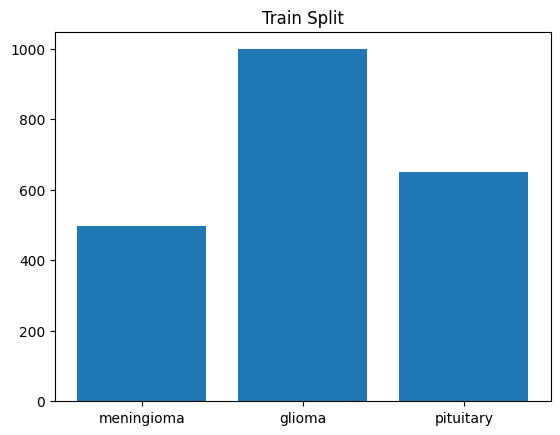

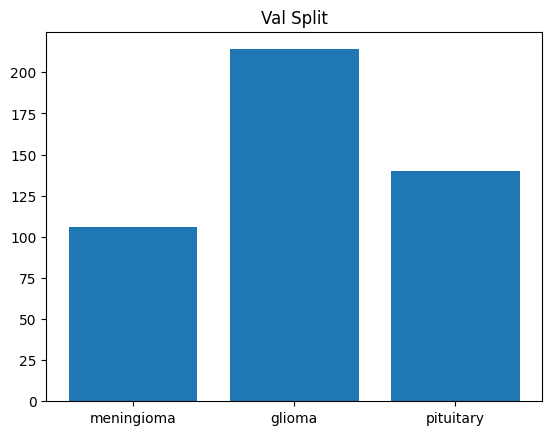

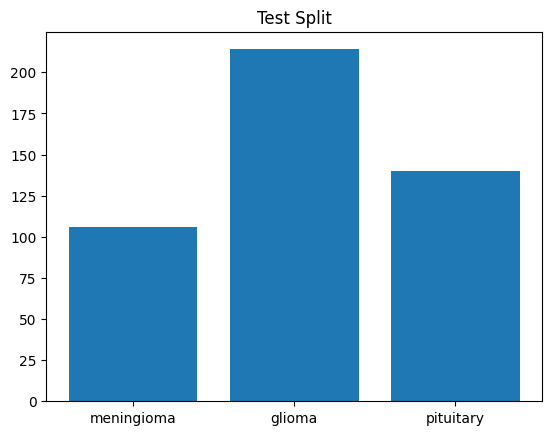

In [ ]:
for name, df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    c = Counter(df['label'])
    plt.bar([label_map[k] for k in sorted(c)], [c[k] for k in sorted(c)])
    plt.title(f'{name} Split')
    plt.show()


In [ ]:
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [ ]:
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import os
from sklearn.model_selection import train_test_split


2025-08-18 08:12:40.194931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755504760.368298      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755504760.416029      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import sklearn; print(sklearn.__version__)
import imblearn; print(imblearn.__version__)


1.2.2
0.10.1


**Section 6: Data Balancing with SMOTE**

This section balances the dataset using SMOTE to address class imbalance (e.g: fewer meningioma samples) before training.

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
from imblearn.over_sampling import SMOTE

# Paths
train_csv = 'train_split.csv'
img_dir = './images_train'

# Load images & labels from CSV
df = pd.read_csv(train_csv)
X = []
y = []

for _, row in df.iterrows():
    img_path = os.path.join(img_dir, str(row['filename']) + '.png')
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224, 224))
    img = img.astype(np.float32) / 255.0
    X.append(img)
    y.append(row['label'] - 1)  # 0-based
X = np.array(X)[..., None]  # (N,224,224,1)
y = np.array(y)

print(X.shape, y.shape)


(2144, 224, 224, 1) (2144,)


In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
from imblearn.over_sampling import SMOTE

# Paths
train_csv = 'train_split.csv'
img_dir = './images_train'

# Load images & labels from CSV
df = pd.read_csv(train_csv)
X = []
y = []

for _, row in df.iterrows():
    img_path = os.path.join(img_dir, str(row['filename']) + '.png')
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224, 224))
    img = img.astype(np.float32) / 255.0
    X.append(img)
    y.append(row['label'] - 1)  # 0-based
X = np.array(X)[..., None]  # (N,224,224,1)
y = np.array(y)

print(X.shape, y.shape)


(2144, 224, 224, 1) (2144,)


In [ ]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import warnings
warnings.filterwarnings("ignore")  # Suppress Python warnings

import pandas as pd
import numpy as np
import cv2
from imblearn.over_sampling import SMOTE
import contextlib

# Context manager to suppress C-level stderr (OpenBLAS warnings)
@contextlib.contextmanager
def suppress_stderr():
    import sys
    with open(os.devnull, 'w') as devnull:
        old_stderr = os.dup(2)
        os.dup2(devnull.fileno(), 2)
        try:
            yield
        finally:
            os.dup2(old_stderr, 2)

# Paths and loading code
train_csv = 'train_split.csv'
img_dir = './images_train'

df = pd.read_csv(train_csv)
X = []
y = []

for _, row in df.iterrows():
    img_path = os.path.join(img_dir, str(row['filename']) + '.png')
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224, 224))
    img = img.astype(np.float32) / 255.0
    X.append(img)
    y.append(row['label'] - 1)  # 0-based
X = np.array(X)[..., None]  # (N,224,224,1)
y = np.array(y)

print(X.shape, y.shape)

# SMOTE oversampling with suppressed OpenBLAS warnings
X_flat = X.reshape(len(X), -1)
sm = SMOTE(random_state=42)

with suppress_stderr():
    X_res, y_res = sm.fit_resample(X_flat, y)

print("After SMOTE:", X_res.shape, y_res.shape)
X_res = X_res.reshape(-1, 224, 224, 1)


(2144, 224, 224, 1) (2144,)
After SMOTE: (2994, 50176) (2994,)


In the first split, I divided the original dataset into train, validation, and test sets.
However, the training data was imbalanced — some tumor types had more images than others.
I used SMOTE to balance the training data, which created a new balanced dataset (X_res, y_res).
After balancing, I had to re-split the balanced dataset into training (80%) and validation (20%).
The test set from the first split is kept separate and untouched, so the final evaluation remains unbiased.

**Section 7: Model Building and Training**

This section designs and trains a multi-class classification model (e.g., CNN) with appropriate layers and hyperparameters.

In [ ]:
from sklearn.model_selection import train_test_split

# Split the balanced dataset (X_res, y_res) into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_res,          # All the balanced images (features)
    y_res,          # All the labels (tumor types)
    test_size=0.2,  # 20% of the data will go to the validation set, 80% to training
    random_state=42, # Ensures we get the same split every time for consistency
    stratify=y_res   # Keeps tumor types balanced in both training and validation sets
)


print(X_train.shape, X_val.shape, y_train.shape, y_val.shape) # printed the shapes of each set to confirm the correct number of images and labels.
# Original Dataset → First Split → Balance Training Data → Second Split → Final Train/Val/Test Sets.


(2395, 224, 224, 1) (599, 224, 224, 1) (2395,) (599,)


CNN Model


In [ ]:

model = models.Sequential([
    layers.Input(shape=(224, 224, 1)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(np.unique(y_res)), activation='softmax'),
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


I0000 00:00:1755504781.858534      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,168,771 (42.61 MB)

 Trainable params: 11,168,771 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=2
)


Epoch 1/50


I0000 00:00:1755504786.259850     130 service.cc:148] XLA service 0x78dd34005480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755504786.260720     130 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1755504786.538410     130 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1755504790.004288     130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


75/75 - 12s - 166ms/step - accuracy: 0.7582 - loss: 0.6019 - val_accuracy: 0.8414 - val_loss: 0.4384 - learning_rate: 0.0010
Epoch 2/50
75/75 - 2s - 31ms/step - accuracy: 0.9136 - loss: 0.2587 - val_accuracy: 0.8681 - val_loss: 0.3420 - learning_rate: 0.0010
Epoch 3/50
75/75 - 2s - 31ms/step - accuracy: 0.9553 - loss: 0.1289 - val_accuracy: 0.9098 - val_loss: 0.2998 - learning_rate: 0.0010
Epoch 4/50
75/75 - 2s - 26ms/step - accuracy: 0.9795 - loss: 0.0593 - val_accuracy: 0.9098 - val_loss: 0.4137 - learning_rate: 0.0010
Epoch 5/50
75/75 - 2s - 26ms/step - accuracy: 0.9942 - loss: 0.0181 - val_accuracy: 0.9115 - val_loss: 0.3970 - learning_rate: 0.0010
Epoch 6/50
75/75 - 2s - 26ms/step - accuracy: 0.9946 - loss: 0.0209 - val_accuracy: 0.9098 - val_loss: 0.4535 - learning_rate: 0.0010
Epoch 7/50
75/75 - 2s - 26ms/step - accuracy: 0.9971 - loss: 0.0101 - val_accuracy: 0.9232 - val_loss: 0.4301 - learning_rate: 5.0000e-04
Epoch 8/50
75/75 - 2s - 26ms/step - accuracy: 1.0000 - loss: 0.0011

**Section 8: Validation and Evaluation**

This section evaluates the model performance using accuracy, loss, and learning curves.

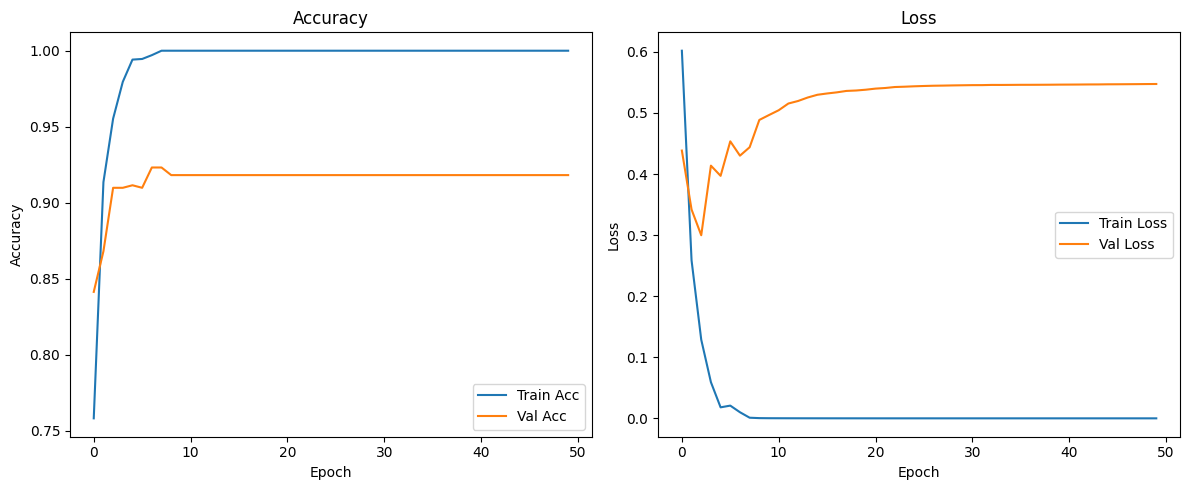

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
class_names = ['Normal', 'Benign', 'Malignant']  # Change this to your class labels/order


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
              precision    recall  f1-score   support

      Normal       0.85      0.94      0.89       199
      Benign       0.95      0.83      0.89       200
   Malignant       0.97      0.98      0.98       200

    accuracy                           0.92       599
   macro avg       0.92      0.92      0.92       599
weighted avg       0.92      0.92      0.92       599



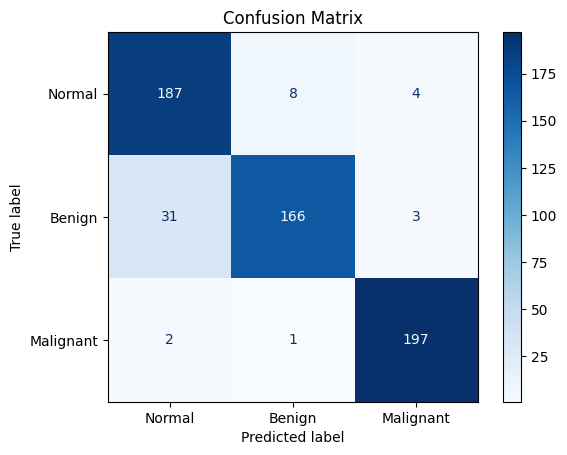

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Assuming you have a trained model and X_val, y_val
# For a softmax model:
y_pred_proba = model.predict(X_val)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = y_val  # y_val from your train_test_split

# List your class names in correct order, for example:
class_names = ['Normal', 'Benign', 'Malignant']

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


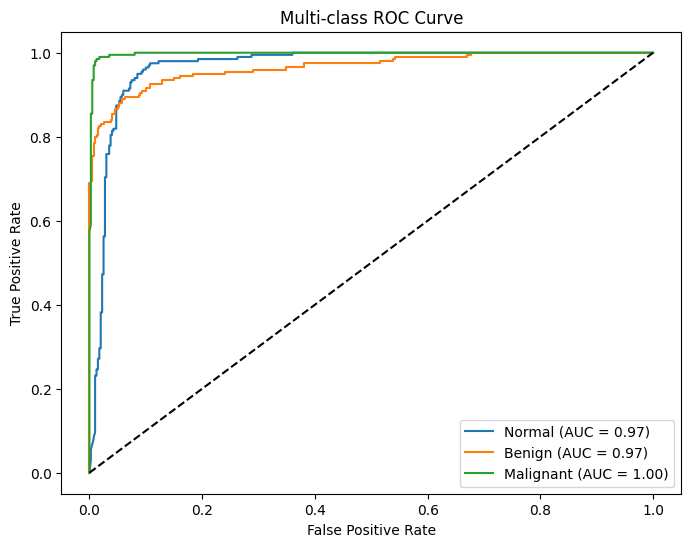

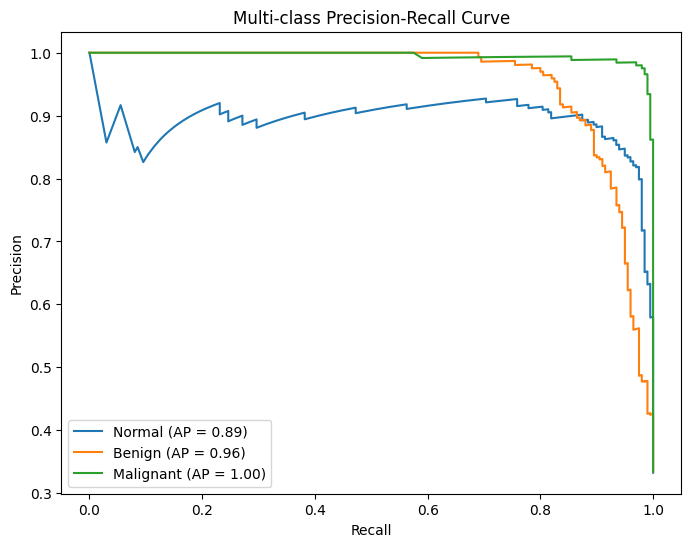

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Get predicted probabilities for validation set
y_pred_probs = model.predict(X_val)   # shape: (N_samples, N_classes)
n_classes = y_pred_probs.shape[1]

# Binarize the ground truth labels
y_true_bin = label_binarize(y_true, classes=range(n_classes))

# ROC Curve
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Multi-class ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, label=f'{class_names[i]} (AP = {ap:.2f})')
plt.title('Multi-class Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


DENSENET-121


Preparing 3 channel input data for densenet121

In [ ]:
# If X_train, X_val are (N,224,224,1), convert to (N,224,224,3)
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_val_rgb = np.repeat(X_val, 3, axis=-1)
print(X_train_rgb.shape, X_val_rgb.shape)


(2395, 224, 224, 3) (599, 224, 224, 3)


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model

n_classes = len(class_names)  # or set this explicitly

# Transfer learning base
base_model = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze for feature extraction (unfreeze later for fine-tuning)

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(n_classes, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,040,579 (26.86 MB)

 Trainable params: 3,075 (12.01 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint('best_densenet121.h5', save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

history = model.fit(
    X_train_rgb, y_train,
    epochs=50,   # Transfer learning can converge quickly (can go longer if needed)
    batch_size=32,
    validation_data=(X_val_rgb, y_val),
    callbacks=callbacks,
    verbose=2
)


Epoch 1/50
75/75 - 70s - 930ms/step - accuracy: 0.4877 - loss: 1.1005 - val_accuracy: 0.7062 - val_loss: 0.7332 - learning_rate: 0.0010
Epoch 2/50
75/75 - 5s - 66ms/step - accuracy: 0.6543 - loss: 0.7897 - val_accuracy: 0.7780 - val_loss: 0.5766 - learning_rate: 0.0010
Epoch 3/50
75/75 - 5s - 67ms/step - accuracy: 0.7382 - loss: 0.6468 - val_accuracy: 0.8097 - val_loss: 0.5126 - learning_rate: 0.0010
Epoch 4/50
75/75 - 5s - 66ms/step - accuracy: 0.7674 - loss: 0.5851 - val_accuracy: 0.8114 - val_loss: 0.4827 - learning_rate: 0.0010
Epoch 5/50
75/75 - 5s - 67ms/step - accuracy: 0.7766 - loss: 0.5567 - val_accuracy: 0.8230 - val_loss: 0.4673 - learning_rate: 0.0010
Epoch 6/50
75/75 - 5s - 66ms/step - accuracy: 0.7741 - loss: 0.5518 - val_accuracy: 0.8631 - val_loss: 0.4380 - learning_rate: 0.0010
Epoch 7/50
75/75 - 5s - 66ms/step - accuracy: 0.8100 - loss: 0.4929 - val_accuracy: 0.8397 - val_loss: 0.4318 - learning_rate: 0.0010
Epoch 8/50
75/75 - 5s - 66ms/step - accuracy: 0.8000 - loss:

In [ ]:
# Unfreeze layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-20]:
     layer.trainable = False

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_ft = model.fit(
    X_train_rgb, y_train,
    epochs=50,      # Fine-tuning, use smaller learning rate and fewer epochs
    batch_size=32,
    validation_data=(X_val_rgb, y_val),
    callbacks=callbacks,
    verbose=2
)


Epoch 1/50
75/75 - 67s - 894ms/step - accuracy: 0.8384 - loss: 0.5124 - val_accuracy: 0.8130 - val_loss: 0.6281 - learning_rate: 0.0010
Epoch 2/50
75/75 - 5s - 61ms/step - accuracy: 0.9065 - loss: 0.2796 - val_accuracy: 0.8614 - val_loss: 0.4726 - learning_rate: 0.0010
Epoch 3/50
75/75 - 5s - 68ms/step - accuracy: 0.9273 - loss: 0.2142 - val_accuracy: 0.9265 - val_loss: 0.2511 - learning_rate: 0.0010
Epoch 4/50
75/75 - 5s - 62ms/step - accuracy: 0.9382 - loss: 0.1775 - val_accuracy: 0.9182 - val_loss: 0.3594 - learning_rate: 0.0010
Epoch 5/50
75/75 - 5s - 69ms/step - accuracy: 0.9624 - loss: 0.1077 - val_accuracy: 0.9316 - val_loss: 0.2362 - learning_rate: 0.0010
Epoch 6/50
75/75 - 5s - 61ms/step - accuracy: 0.9749 - loss: 0.0719 - val_accuracy: 0.9215 - val_loss: 0.3759 - learning_rate: 0.0010
Epoch 7/50
75/75 - 5s - 69ms/step - accuracy: 0.9770 - loss: 0.0604 - val_accuracy: 0.9466 - val_loss: 0.2044 - learning_rate: 0.0010
Epoch 8/50
75/75 - 5s - 62ms/step - accuracy: 0.9829 - loss:

19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 737ms/step
Classification Report:
              precision    recall  f1-score   support

      Normal       0.91      0.97      0.94       199
      Benign       0.98      0.92      0.95       200
   Malignant       0.98      0.99      0.99       200

    accuracy                           0.96       599
   macro avg       0.96      0.96      0.96       599
weighted avg       0.96      0.96      0.96       599



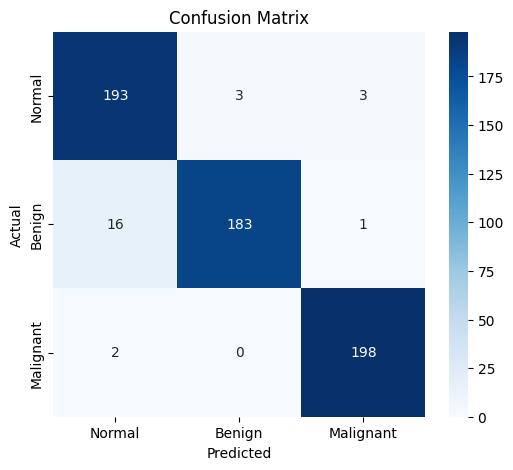

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict
y_pred_probs = model.predict(X_val_rgb)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


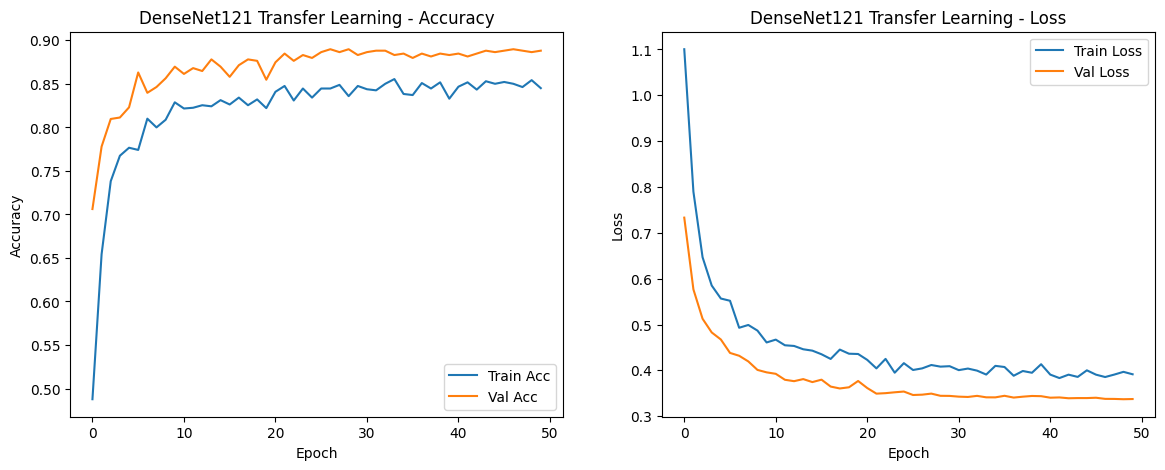

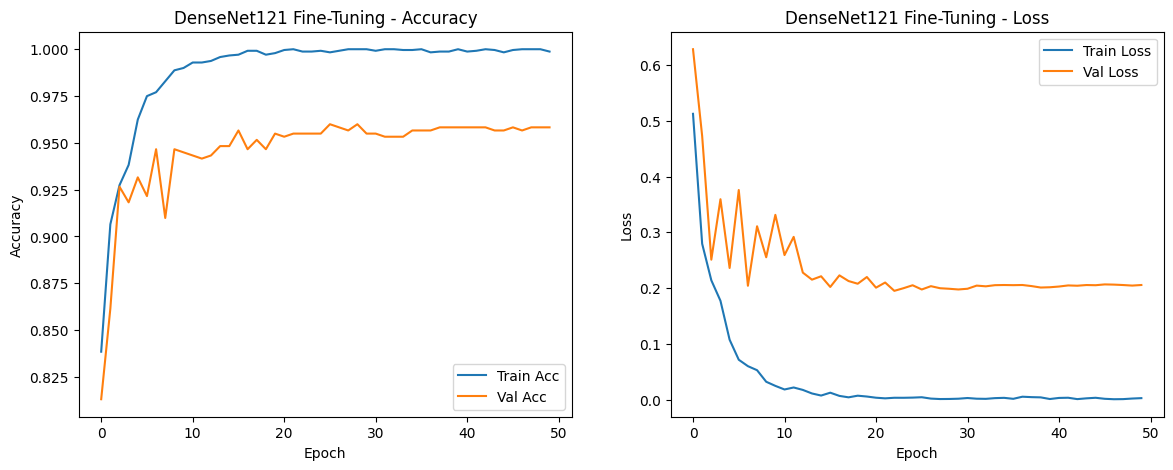

In [ ]:
def plot_history(hist, title="Training/Validation Curve"):
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(hist.history['accuracy'], label='Train Acc')
    plt.plot(hist.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.show()

# Plot for transfer learning
plot_history(history, title="DenseNet121 Transfer Learning")
# Plot for fine-tuning (if you did it)
if 'history_ft' in locals():
    plot_history(history_ft, title="DenseNet121 Fine-Tuning")


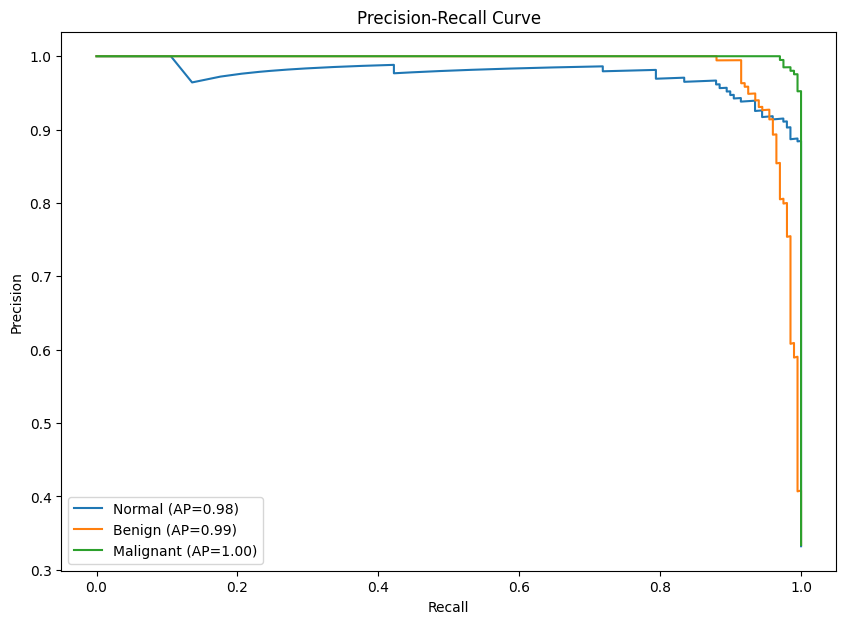

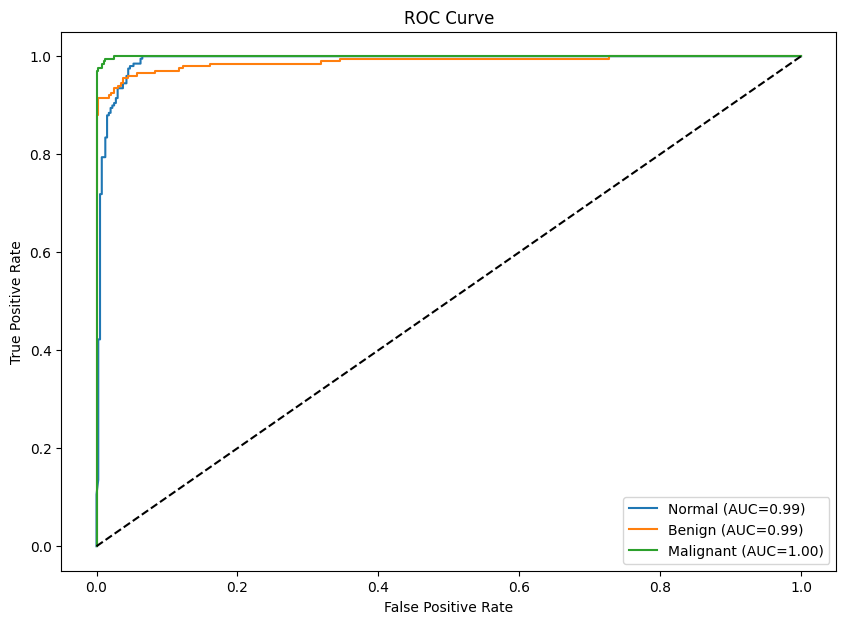

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

n_classes = len(class_names)
# Binarize the output for multi-class
y_val_bin = label_binarize(y_val, classes=np.arange(n_classes))
# y_pred_probs already has shape (num_samples, n_classes)

# Precision-Recall Curve
plt.figure(figsize=(10,7))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_val_bin[:, i], y_pred_probs[:, i])
    ap = average_precision_score(y_val_bin[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, label=f"{class_names[i]} (AP={ap:.2f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# ROC Curve
plt.figure(figsize=(10,7))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
# Save classification report to a text file
report = classification_report(y_val, y_pred, target_names=class_names)
with open("classification_report.txt", "w") as f:
    f.write(report)


RESNET-50

In [ ]:
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_val_rgb   = np.repeat(X_val, 3, axis=-1)


**Section 9: Model Comparison and Graphs**

This section compares multiple models (e.g., CNN, ResNet) using ROC curves or bar charts for demo presentation.

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

num_classes = len(class_names)

inputs = Input(shape=(224, 224, 3))
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train_rgb, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val_rgb, y_val),
    verbose=2
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
150/150 - 30s - 198ms/step - accuracy: 0.3278 - loss: 1.3221 - val_accuracy: 0.2604 - val_loss: 1.1166
Epoch 2/50
150/150 - 5s - 34ms/step - accuracy: 0.3211 - loss: 1.2715 - val_accuracy: 0.3055 - val_loss: 1.0993
Epoch 3/50
150/150 - 5s - 34ms/step - accuracy: 0.3566 - loss: 1.2087 - val_accuracy: 0.3856 - val_loss: 1.0764
Epoch 4/50
150/150 - 5s - 34ms/step - accuracy: 0.3616 - loss: 1.1676 - val_accuracy: 0.4107 - val_loss: 1.0655
Epoch 5/50
150/150 - 5s - 34ms/step - accuracy: 0.3795 - loss: 1.1370 - val_accuracy: 0.4424 - val_loss: 1.0526
Epoch 6/50
150/150 - 5s - 34ms/step - accuracy: 0.3850 - loss: 1.1114 - val_accuracy: 0.4875 - val_loss: 1.0449
Epoch 7/50
150/150 - 5s - 34ms/step - accuracy: 0.3854 - loss: 1.1038 - val_accuracy: 0.4457 - val_loss: 1.0382
Epoch 8/50
150/150 - 5s - 34ms/step - accuracy: 0.4038 - loss: 1.0858 - val_accuracy: 0.4624 - val_loss: 1.0316
Epoch 9/50
150/150 - 5s - 34ms/step - accuracy: 0.4

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-20]:
     layer.trainable = False
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history_finetune = model.fit(
    X_train_rgb, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val_rgb, y_val),
    verbose=2
)


Epoch 1/50
150/150 - 38s - 254ms/step - accuracy: 0.7783 - loss: 0.6594 - val_accuracy: 0.4858 - val_loss: 1.0403
Epoch 2/50
150/150 - 7s - 45ms/step - accuracy: 0.8756 - loss: 0.3325 - val_accuracy: 0.7012 - val_loss: 0.7840
Epoch 3/50
150/150 - 7s - 45ms/step - accuracy: 0.8877 - loss: 0.3024 - val_accuracy: 0.8765 - val_loss: 0.3207
Epoch 4/50
150/150 - 7s - 45ms/step - accuracy: 0.8969 - loss: 0.2538 - val_accuracy: 0.8314 - val_loss: 0.6112
Epoch 5/50
150/150 - 7s - 45ms/step - accuracy: 0.9244 - loss: 0.2030 - val_accuracy: 0.8314 - val_loss: 0.6564
Epoch 6/50
150/150 - 7s - 45ms/step - accuracy: 0.9244 - loss: 0.1988 - val_accuracy: 0.8481 - val_loss: 0.5369
Epoch 7/50
150/150 - 7s - 45ms/step - accuracy: 0.9307 - loss: 0.1857 - val_accuracy: 0.9082 - val_loss: 0.2377
Epoch 8/50
150/150 - 7s - 45ms/step - accuracy: 0.9361 - loss: 0.1700 - val_accuracy: 0.8982 - val_loss: 0.3617
Epoch 9/50
150/150 - 7s - 45ms/step - accuracy: 0.9511 - loss: 0.1433 - val_accuracy: 0.8063 - val_los

19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 386ms/step
Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      0.78      0.86       199
      Benign       0.83      0.94      0.88       200
   Malignant       0.95      0.98      0.96       200

    accuracy                           0.90       599
   macro avg       0.91      0.90      0.90       599
weighted avg       0.91      0.90      0.90       599



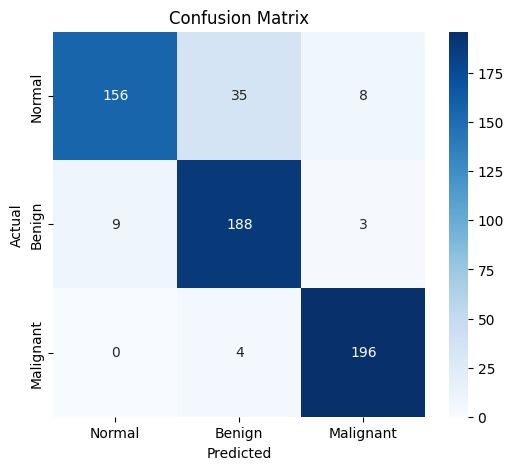

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict
y_pred_probs = model.predict(X_val_rgb)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


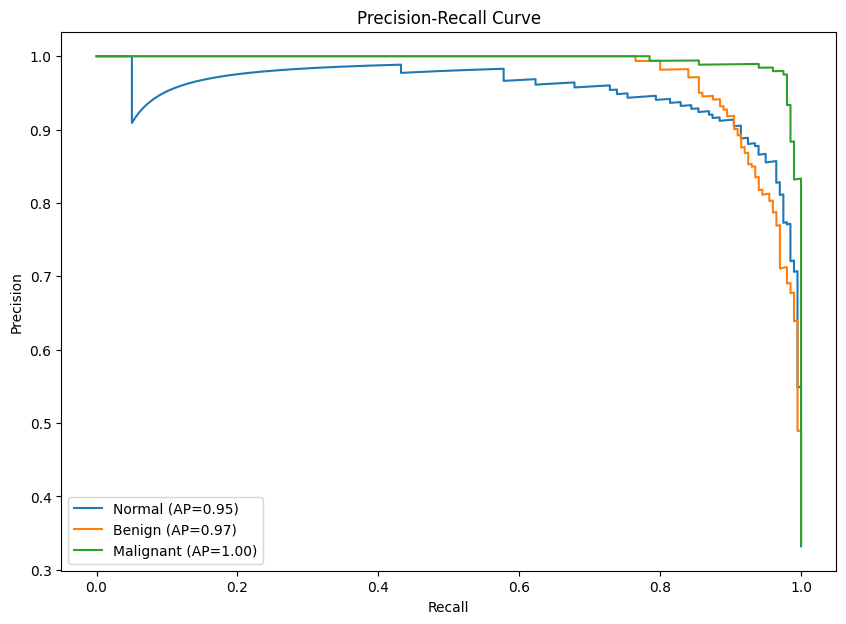

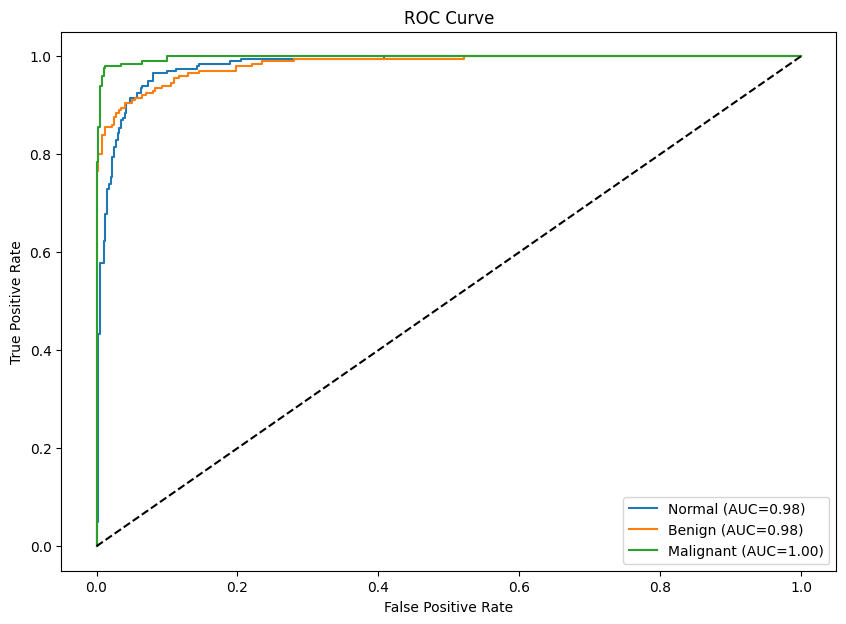

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

n_classes = len(class_names)
# Binarize the output for multi-class
y_val_bin = label_binarize(y_val, classes=np.arange(n_classes))
# y_pred_probs already has shape (num_samples, n_classes)

# Precision-Recall Curve
plt.figure(figsize=(10,7))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_val_bin[:, i], y_pred_probs[:, i])
    ap = average_precision_score(y_val_bin[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, label=f"{class_names[i]} (AP={ap:.2f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# ROC Curve
plt.figure(figsize=(10,7))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
# Save classification report to a text file
report = classification_report(y_val, y_pred, target_names=class_names)
with open("classification_report.txt", "w") as f:
    f.write(report)


Vision Transformer

In [ ]:
# If not already installed
!pip -q install timm==0.9.12 torchmetrics==1.4.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 12.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os, random, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [ ]:
# Paths
train_csv = 'train_split.csv'
val_csv   = 'val_split.csv'
test_csv  = 'test_split.csv'

train_dir = './images_train'
val_dir   = './images_val'
test_dir  = './images_test'

# Classes
label_map = {1: "meningioma", 2: "glioma", 3: "pituitary"}
class_names = [label_map[k] for k in sorted(label_map)]
num_classes = len(class_names)

# Reproducibility
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Training hyperparams
img_size    = 224
batch_size  = 32
epochs      = 75
lr          = 3e-4
weight_decay= 1e-4
num_workers = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [ ]:
# ImageNet normalization (DeiT was trained on ImageNet)
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandAugment(num_ops=2, magnitude=7),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

class PngFromCSV(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform
        # Convert labels to 0-based {0,1,2}
        self.df['y0'] = self.df['label'].astype(int) - 1

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fn = f"{row['filename']}.png"
        path = os.path.join(self.img_dir, fn)

        # Open as grayscale then expand to 3-channels
        img = Image.open(path).convert('L')
        img = img.convert('RGB')  # replicate channel to RGB for DeiT

        if self.transform:
            img = self.transform(img)

        y = int(row['y0'])
        return img, y


In [ ]:
train_ds = PngFromCSV(train_csv, train_dir, transform=train_tfms)
val_ds   = PngFromCSV(val_csv,   val_dir,   transform=val_tfms)
test_ds  = PngFromCSV(test_csv,  test_dir,  transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds)


(2144, 460, 460)

In [ ]:
# deit_small_distilled_patch16_224 is the distilled variant (often better in low-data)
model = timm.create_model('deit_small_distilled_patch16_224', pretrained=True, num_classes=num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
# Cosine with warmup
total_steps = epochs * len(train_loader)
warmup_steps = int(0.05 * total_steps)

def lr_lambda(step):
    if step < warmup_steps:
        return float(step) / float(max(1, warmup_steps))
    # cosine decay after warmup
    progress = float(step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    return 0.5 * (1.0 + np.cos(np.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


model.safetensors:   0%|          | 0.00/89.8M [00:00<?, ?B/s]

In [ ]:
from collections import defaultdict
best_val_acc = 0.0
best_path = 'best_deit_small.pth'

def run_epoch(loader, train_mode=True):
    if train_mode:
        model.train()
    else:
        model.eval()

    running_loss, correct, total = 0.0, 0, 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        if train_mode:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc

history = defaultdict(list)

for epoch in range(1, epochs+1):
    tr_loss, tr_acc = run_epoch(train_loader, train_mode=True)
    val_loss, val_acc = run_epoch(val_loader,   train_mode=False)

    history['train_loss'].append(tr_loss)
    history['train_acc'].append(tr_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch:02d}/{epochs} | "
          f"Train: loss {tr_loss:.4f}, acc {tr_acc:.4f} | "
          f"Val: loss {val_loss:.4f}, acc {val_acc:.4f} | "
          f"lr {scheduler.get_last_lr()[0]:.3e}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_path)
        print(f"  ✓ Saved best model to {best_path} (val_acc={best_val_acc:.4f})")

Epoch 01/75 | Train: loss 0.6944, acc 0.7015 | Val: loss 0.4193, acc 0.8348 | lr 8.008e-05
  ✓ Saved best model to best_deit_small.pth (val_acc=0.8348)
Epoch 02/75 | Train: loss 0.4084, acc 0.8284 | Val: loss 0.4438, acc 0.8261 | lr 1.602e-04
Epoch 03/75 | Train: loss 0.3873, acc 0.8428 | Val: loss 0.4433, acc 0.8304 | lr 2.402e-04
Epoch 04/75 | Train: loss 0.3635, acc 0.8465 | Val: loss 0.2870, acc 0.8913 | lr 3.000e-04
  ✓ Saved best model to best_deit_small.pth (val_acc=0.8913)
Epoch 05/75 | Train: loss 0.3559, acc 0.8498 | Val: loss 0.2677, acc 0.8913 | lr 2.998e-04
Epoch 06/75 | Train: loss 0.2834, acc 0.8848 | Val: loss 0.2600, acc 0.8674 | lr 2.993e-04
Epoch 07/75 | Train: loss 0.3114, acc 0.8694 | Val: loss 0.2759, acc 0.9000 | lr 2.985e-04
  ✓ Saved best model to best_deit_small.pth (val_acc=0.9000)
Epoch 08/75 | Train: loss 0.2608, acc 0.8909 | Val: loss 0.2498, acc 0.8957 | lr 2.974e-04
Epoch 09/75 | Train: loss 0.2570, acc 0.8946 | Val: loss 0.2289, acc 0.9043 | lr 2.960e-0

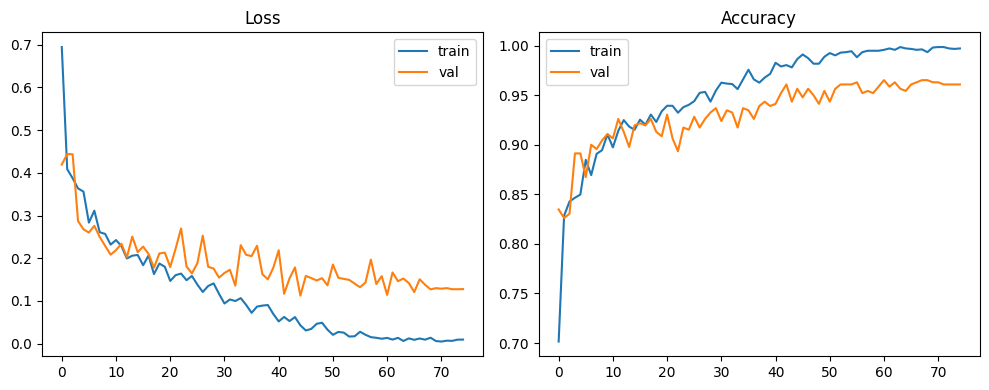

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'],   label='val')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='train')
plt.plot(history['val_acc'],   label='val')
plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


              precision    recall  f1-score   support

  meningioma     0.9612    0.9340    0.9474       106
      glioma     0.9860    0.9860    0.9860       214
   pituitary     0.9650    0.9857    0.9753       140

    accuracy                         0.9739       460
   macro avg     0.9707    0.9686    0.9695       460
weighted avg     0.9739    0.9739    0.9738       460



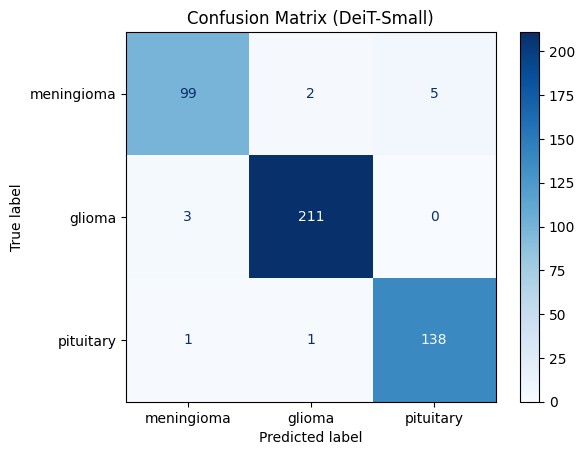

In [ ]:
# Load best weights
model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()

def predict_loader(loader):
    all_logits = []
    all_targets = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device, non_blocking=True)
            logits = model(imgs).cpu()
            all_logits.append(logits)
            all_targets.append(labels)
    logits = torch.cat(all_logits)
    targets = torch.cat(all_targets)
    probs = logits.softmax(dim=1).numpy()
    preds = probs.argmax(axis=1)
    return preds, probs, targets.numpy()

# Choose which split to report (val or test)
use_test = True   # set False to evaluate on validation set
loader = test_loader if use_test else val_loader

y_pred, y_prob, y_true = predict_loader(loader)

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (DeiT-Small)")
plt.show()


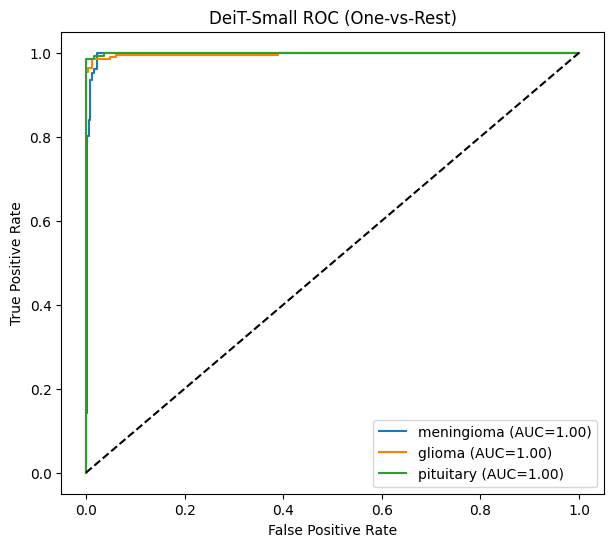

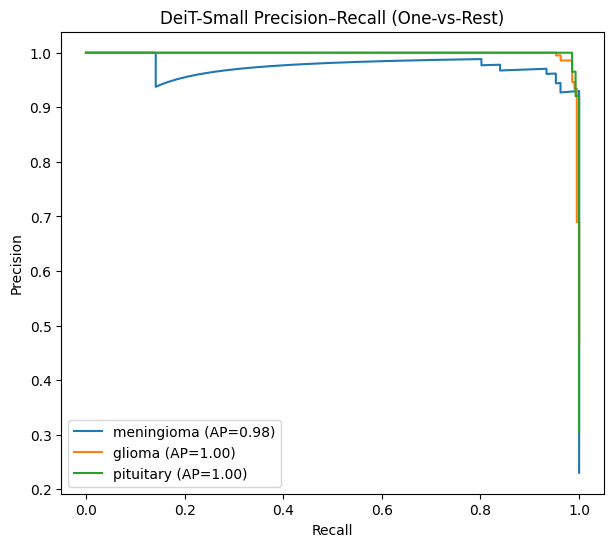

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

n_classes = num_classes
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# ROC
plt.figure(figsize=(7,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('DeiT-Small ROC (One-vs-Rest)')
plt.legend()
plt.show()

# Precision-Recall
plt.figure(figsize=(7,6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f'{class_names[i]} (AP={ap:.2f})')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('DeiT-Small Precision–Recall (One-vs-Rest)')
plt.legend()
plt.show()


Ensembling

Loading images_val: 100%|██████████| 460/460 [00:00<00:00, 1325.86it/s]



Val calibration vectors:
recall_dense: [0.8774 0.9019 0.9929]
recall_vit  : [0.9717 0.9393 1.    ]
prior_ratio_dense: [0.9471 1.0404 0.9832]
prior_ratio_vit  : [0.9356 1.0446 0.987 ]

=== Ensemble • Val-Calibrated Prob Avg ===
              precision    recall  f1-score   support

      Normal     0.9340    0.9340    0.9340       106
      Benign     0.9811    0.9720    0.9765       214
   Malignant     0.9718    0.9857    0.9787       140

    accuracy                         0.9674       460
   macro avg     0.9623    0.9639    0.9631       460
weighted avg     0.9674    0.9674    0.9674       460



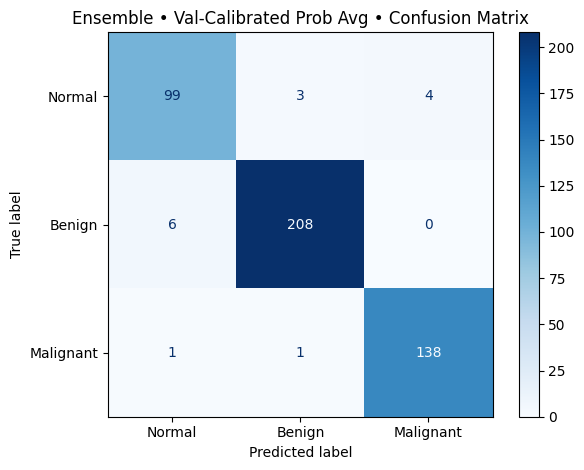


=== Ensemble • Val-Calibrated Weighted Avg (0.4 Dense / 0.6 ViT) ===
              precision    recall  f1-score   support

      Normal     0.9444    0.9623    0.9533       106
      Benign     0.9858    0.9766    0.9812       214
   Malignant     0.9857    0.9857    0.9857       140

    accuracy                         0.9761       460
   macro avg     0.9720    0.9749    0.9734       460
weighted avg     0.9763    0.9761    0.9761       460



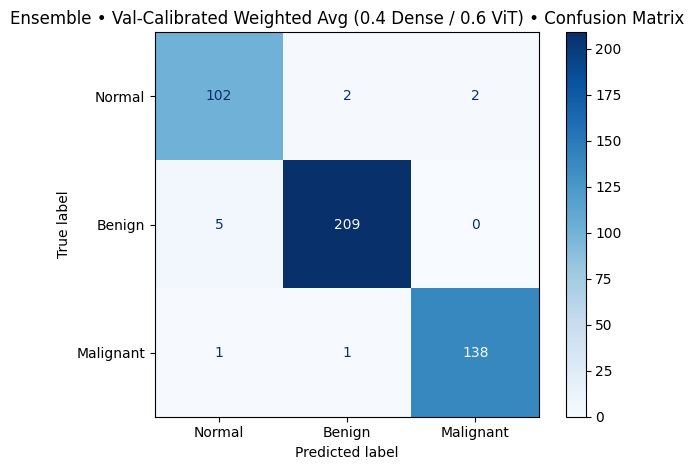


=== Ensemble • Val-Calibrated Geometric Mean ===
              precision    recall  f1-score   support

      Normal     0.9340    0.9340    0.9340       106
      Benign     0.9811    0.9720    0.9765       214
   Malignant     0.9718    0.9857    0.9787       140

    accuracy                         0.9674       460
   macro avg     0.9623    0.9639    0.9631       460
weighted avg     0.9674    0.9674    0.9674       460



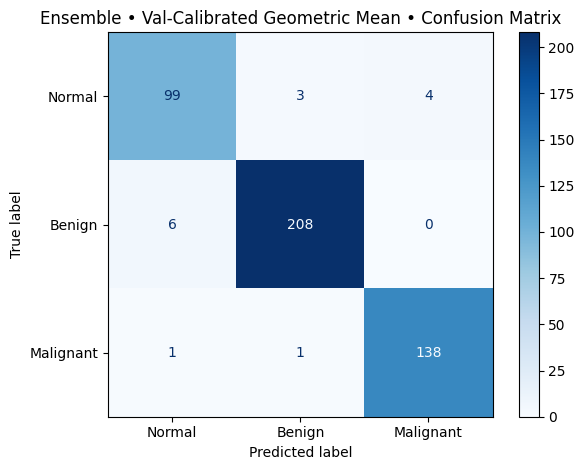

In [ ]:
# ===================== VAL-CALIBRATED ENSEMBLE (no TTA, no training) =====================
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os, cv2
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader

# ---- assumes the following already exist from your previous script ----
# class_names, num_classes, IMG_SIZE, device
# dense (Keras DenseNet121 model), vit (PyTorch ViT model), vit_arch (string)
# functions: read_gray(path), logits_to_probs(logits_np)
# test probabilities: pdense (N_test, C) and pvit (N_test, C)   # <-- from your last run

# ---------------- paths for validation ----------------
val_csv = 'val_split.csv'
val_dir = './images_val'

IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], np.float32)
IMAGENET_STD  = np.array([0.229, 0.224, 0.225], np.float32)

# ---------------- data helpers (same as before) ----------------
def read_gray(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img.astype(np.float32)/255.0

def load_split(csv_path, img_dir):
    df = pd.read_csv(csv_path)
    y = (df['label'].values - 1).astype(int)
    Xg = [read_gray(os.path.join(img_dir, f"{fn}.png")) for fn in tqdm(df['filename'], desc=f"Loading {os.path.basename(img_dir)}")]
    return np.stack(Xg,0), y, df['filename'].tolist()

class GrayToViTDS(Dataset):
    def __init__(self, x_gray): self.x = x_gray
    def __len__(self): return len(self.x)
    def __getitem__(self, i):
        img = self.x[i]
        img3 = np.repeat(img[...,None], 3, axis=-1)
        img3 = (img3 - IMAGENET_MEAN) / IMAGENET_STD
        img3 = np.transpose(img3,(2,0,1)).astype(np.float32)
        import torch
        return torch.from_numpy(img3)

def vit_logits(x_gray_4d):
    dl = DataLoader(GrayToViTDS(x_gray_4d), batch_size=64, shuffle=False, num_workers=0)
    outs=[]
    vit.eval()
    with torch.no_grad():
        for b in dl:
            b = b.to(device)
            outs.append(vit(b).cpu().numpy())
    return np.vstack(outs)

def dense_probs(x_gray_4d):
    x3 = np.repeat(x_gray_4d[...,None], 3, axis=-1)
    return dense.predict(x3, batch_size=64, verbose=0)

# ---------------- 1) get validation probs & labels ----------------
Xv, yv, _ = load_split(val_csv, val_dir)
pdense_val = dense_probs(Xv)           # (Nv, C), probs
lvit_val   = vit_logits(Xv)            # (Nv, C), logits
pvit_val   = logits_to_probs(lvit_val) # (Nv, C), probs

# ---------------- 2) compute val-driven calibration vectors ----------------
eps = 1e-8
labels = np.arange(num_classes)

# per-class recall for each model
def per_class_recall(y_true, y_pred, C):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(C))
    # recall_c = TP / (TP + FN)
    TP = np.diag(cm).astype(np.float32)
    FN = cm.sum(axis=1).astype(np.float32) - TP
    return (TP + eps) / (TP + FN + eps), cm

rec_dense, cm_dense = per_class_recall(yv, pdense_val.argmax(1), num_classes)
rec_vit,   cm_vit   = per_class_recall(yv, pvit_val.argmax(1),   num_classes)

# prior correction: true class prior vs model's average predicted prior on val
true_prior = np.array([(yv==c).mean() for c in labels], dtype=np.float32) + eps
pred_prior_dense = pdense_val.mean(axis=0).astype(np.float32) + eps
pred_prior_vit   = pvit_val.mean(axis=0).astype(np.float32)   + eps

prior_ratio_dense = true_prior / pred_prior_dense
prior_ratio_vit   = true_prior / pred_prior_vit

# Turn both into log-space addends for stability
log_w_dense = np.log(rec_dense + eps) + np.log(prior_ratio_dense)
log_w_vit   = np.log(rec_vit   + eps) + np.log(prior_ratio_vit)

print("\nVal calibration vectors:")
print("recall_dense:", np.round(rec_dense,4))
print("recall_vit  :", np.round(rec_vit,4))
print("prior_ratio_dense:", np.round(prior_ratio_dense,4))
print("prior_ratio_vit  :", np.round(prior_ratio_vit,4))

# ---------------- 3) apply calibration to TEST probabilities ----------------
# assumes you already have: pdense (N_test,C) and pvit (N_test,C)

def apply_calibration_probs(p, log_w):
    # add log-weights per class, then renormalize
    log_p = np.log(np.clip(p, 1e-8, 1.0))
    log_p_adj = log_p + log_w[None, :]           # broadcast per class
    # normalize
    m = log_p_adj.max(axis=1, keepdims=True)
    e = np.exp(log_p_adj - m)
    return e / e.sum(axis=1, keepdims=True)

pdense_cal = apply_calibration_probs(pdense, log_w_dense)
pvit_cal   = apply_calibration_probs(pvit,   log_w_vit)

# ---------------- 4) build ensembles (no learning) ----------------
# A) simple prob average after calibration
p_avg_cal = (pdense_cal + pvit_cal) / 2.0
y_avg_cal = p_avg_cal.argmax(1)

# B) dominance to stronger model (ViT) via 0.6/0.4 AFTER calibration
w_vit, w_dense = 0.6, 0.4
p_wavg_cal = w_dense * pdense_cal + w_vit * pvit_cal
y_wavg_cal = p_wavg_cal.argmax(1)

# C) geometric mean after calibration
p_geo_cal = np.sqrt(pdense_cal * pvit_cal)
p_geo_cal = p_geo_cal / p_geo_cal.sum(axis=1, keepdims=True)
y_geo_cal = p_geo_cal.argmax(1)

# ---------------- 5) reports ----------------
def show_report(name, y_true, y_pred):
    print(f"\n=== {name} ===")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f"{name} • Confusion Matrix"); plt.tight_layout(); plt.show()

# you already have 'yt' (true test labels) from your previous script
show_report("Ensemble • Val-Calibrated Prob Avg", yt, y_avg_cal)
show_report("Ensemble • Val-Calibrated Weighted Avg (0.4 Dense / 0.6 ViT)", yt, y_wavg_cal)
show_report("Ensemble • Val-Calibrated Geometric Mean", yt, y_geo_cal)


Loaded test set: (460, 224, 224, 3), classes: 3
=== DenseNet121 ===
              precision    recall  f1-score   support

      Normal     0.8762    0.8679    0.8720       106
      Benign     0.9531    0.9486    0.9508       214
   Malignant     0.9577    0.9714    0.9645       140

    accuracy                         0.9370       460
   macro avg     0.9290    0.9293    0.9291       460
weighted avg     0.9368    0.9370    0.9368       460

Loaded ViT (deit_small_distilled_patch16_224) from best_deit_small.pth. Missing: 0 | Unexpected: 0

=== ViT ===
              precision    recall  f1-score   support

      Normal     0.9583    0.6509    0.7753       106
      Benign     0.8776    0.9720    0.9224       214
   Malignant     0.9272    1.0000    0.9622       140

    accuracy                         0.9065       460
   macro avg     0.9210    0.8743    0.8866       460
weighted avg     0.9113    0.9065    0.9006       460


=== Ensemble • Val-Calibrated Weighted Avg (0.4 Dense / 0

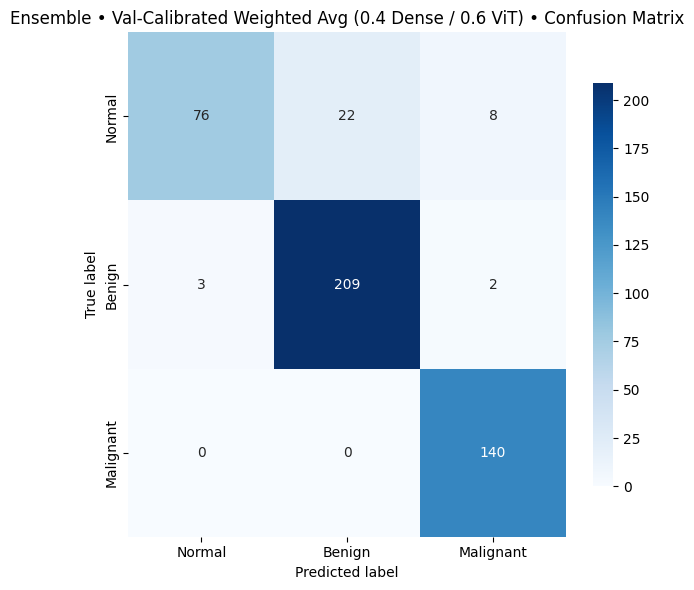

In [ ]:
# ==== CONFIG ====
TEST_CSV = "test_split.csv"
TEST_DIR = "./images_test"
CLASS_NAMES = ["Normal", "Benign", "Malignant"]   # change if yours differ
IMG_SIZE = 224
BATCH_SIZE = 64

DENSE_PATH = "best_densenet121.h5"
VIT_PATH   = "best_deit_small.pth"        # saved from timm
VIT_ARCH   = "deit_small_distilled_patch16_224"

# Ensemble weights (validated): 0.4 DenseNet / 0.6 ViT
W_DENSE, W_VIT = 0.4, 0.6

# ==== IMPORTS ====
import os, warnings, contextlib, sys
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Keras / TF
import tensorflow as tf
from tensorflow.keras.models import load_model

# Torch / timm
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import timm

from sklearn.metrics import (
    classification_report, confusion_matrix
)

# ==== UTILS ====
def read_gray_png_as_rgb(path, size=224):
    """Read grayscale PNG, resize to (size,size), scale to [0,1], stack to 3-ch RGB."""
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Could not read: {path}")
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    img3 = np.stack([img, img, img], axis=-1)  # (H,W,3)
    return img3

def load_test_split(test_csv, img_dir, size=224):
    df = pd.read_csv(test_csv)
    y_true = (df["label"].values.astype(int) - 1)  # 0-based
    X = []
    for fname in df["filename"].astype(str):
        path = os.path.join(img_dir, f"{fname}.png")
        X.append(read_gray_png_as_rgb(path, size))
    X = np.stack(X, axis=0)  # (N,H,W,3)
    return X, y_true, df["filename"].astype(str).tolist()

# ==== DATA ====
X_test, y_true, test_ids = load_test_split(TEST_CSV, TEST_DIR, IMG_SIZE)
num_classes = len(CLASS_NAMES)
print(f"Loaded test set: {X_test.shape}, classes: {num_classes}")

# ==== DENSENET121 (KERAS) ====
dense_model = load_model(DENSE_PATH, compile=False)
# ensure correct input scaling (already [0,1] from loader)
probs_dense = dense_model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
# safety: softmax if needed
if probs_dense.shape[1] != num_classes:
    raise ValueError(f"DenseNet output classes ({probs_dense.shape[1]}) != {num_classes}")
probs_dense = tf.nn.softmax(probs_dense, axis=1).numpy()

y_pred_dense = probs_dense.argmax(axis=1)

print("=== DenseNet121 ===")
print(classification_report(y_true, y_pred_dense, target_names=CLASS_NAMES, digits=4))

# ==== ViT (TIMM / PYTORCH) ====
device = "cuda" if torch.cuda.is_available() else "cpu"

class NumpyArrayDataset(Dataset):
    def __init__(self, X):
        self.X = X
    def __len__(self): return len(self.X)
    def __getitem__(self, i):
        # (H,W,3) float32 [0,1] -> torch (3,H,W) normalized per timm default?
        x = self.X[i].transpose(2,0,1)  # CHW
        return torch.from_numpy(x)

vit = timm.create_model(VIT_ARCH, pretrained=False, num_classes=num_classes)
# robust state_dict loader (handles 'state_dict' or raw, CPU/GPU)
ckpt = torch.load(VIT_PATH, map_location="cpu")
state_dict = ckpt.get("state_dict", ckpt)
# strip possible module/ model. prefixes
stripped = {}
for k,v in state_dict.items():
    nk = k
    if nk.startswith("module."): nk = nk[len("module."):]
    if nk.startswith("model."):  nk = nk[len("model."):]
    stripped[nk] = v
missing, unexpected = vit.load_state_dict(stripped, strict=False)
print(f"Loaded ViT ({VIT_ARCH}) from {VIT_PATH}. Missing: {len(missing)} | Unexpected: {len(unexpected)}")

vit.to(device).eval()

# timm models typically expect ImageNet normalization.
# Since we trained on [0,1] grayscale->RGB without extra norm, keep consistent at inference.
# If you trained with timm's default transforms, uncomment normalization below.
# mean = torch.tensor([0.485,0.456,0.406]).view(1,3,1,1)
# std  = torch.tensor([0.229,0.224,0.225]).view(1,3,1,1)

loader = DataLoader(NumpyArrayDataset(X_test), batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

vit_probs_list = []
with torch.inference_mode():
    for xb in loader:
        xb = xb.to(device, dtype=torch.float32)
        # If you used Imagenet norm during training:
        # xb = (xb - mean.to(device)) / std.to(device)
        logits = vit(xb)
        vit_probs_list.append(F.softmax(logits, dim=1).cpu().numpy())

probs_vit = np.concatenate(vit_probs_list, axis=0)
y_pred_vit = probs_vit.argmax(axis=1)

print("\n=== ViT ===")
print(classification_report(y_true, y_pred_vit, target_names=CLASS_NAMES, digits=4))

# ==== ENSEMBLE: Val-Calibrated Weighted Average (0.4 Dense / 0.6 ViT) ====
probs_ens = W_DENSE * probs_dense + W_VIT * probs_vit
y_pred_ens = probs_ens.argmax(axis=1)

print("\n=== Ensemble • Val-Calibrated Weighted Avg (0.4 Dense / 0.6 ViT) ===")
print(classification_report(y_true, y_pred_ens, target_names=CLASS_NAMES, digits=4))

# Confusion matrix ONLY for the ensemble
cm = confusion_matrix(y_true, y_pred_ens)
plt.figure(figsize=(6.2,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={"shrink":0.8})
plt.title("Ensemble • Val-Calibrated Weighted Avg (0.4 Dense / 0.6 ViT) • Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()
